# 19.03 Meeting (and Not Meeting) the Assumptions of Linear Regression
## Assignment 01

### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [46]:
import warnings

import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import linear_model
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats.stats import pearsonr
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "weatherinszeged"
)

In [24]:
engine=create_engine(URL(**kagle), echo=True)

weather_raw = pd.read_sql_query("SELECT * FROM weatherinszeged", con=engine)

engine.dispose()

2019-12-30 08:31:19,629 INFO sqlalchemy.engine.base.Engine select version()
2019-12-30 08:31:19,631 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 08:31:19,727 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-30 08:31:19,730 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 08:31:19,845 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-30 08:31:19,848 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 08:31:19,898 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-30 08:31:19,900 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 08:31:19,954 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-30 08:31:19,958 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 08:31:20,054 INFO sqlalchemy.engine.base.Engine SELECT * FROM weatherinszeged
2019-12-30 08:31:20,056 INFO sqlalchemy.engine.base.Engine {}


- target_var: temperature
- explanatory_vars: _humidity_, _windspeed_, & _pressure_

| Col_Name | Type | &nbsp; &nbsp; &nbsp; &nbsp; non-null | &nbsp; &nbsp; &nbsp; &nbsp; note |
| :----- | :---| -----: | :----- |
| date | datetime64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered |
| summary | object | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 
| preciptype | object | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 
| temperature | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; _target var_ | 
| apparenttemperature &nbsp; &nbsp; &nbsp; &nbsp; | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 
| humidity | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; _explanatory var_ | 
| windspeed | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; _explanatory var_ | 
| visibility | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 
| loudcover | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 
| pressure | float64 | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; _explanatory var_ | 
| dailysummary | object | 96453 | &nbsp; &nbsp; &nbsp; &nbsp; not considered | 

In [25]:
# temperature is the target variable Y 
Y = weather_raw["temperature"] 

# the explanatory variables (humidity, windspeed, and pressure) are the featue set X
X = weather_raw[["humidity","windspeed","pressure"]]

# instantiate a LinearRegression modle
lrm = linear_model.LinearRegression()

# Fit method estimates of the coefficients using OLS
lrm.fit(X,Y)

print(f"\nCoefficients: \n\t{lrm.coef_}")
print(f"\nIntercept: \n\t{lrm.intercept_}")


Coefficients: 
	[-3.24398999e+01 -1.94546893e-01 -7.15579969e-04]

Intercept: 
	38.59379935054457


## Assumption One: Linearity of the Model in its Coefficients

`LinearRegression`'s `fit()` returns a model with this assumption: $ y = \beta_0 + \beta_1x_1 + beta_2x_2 + \beta_3x_3 $ and this construction: $$ temperature = 38.59 + -3.24 humidity + -0.194 windspeed + -0.000715 pressure \qquad(eq.1) $$
- the coefficients in $ (eq.1) $ have been abbreviated for presentation sake.

Mean of the errors in the temperature model is: -1.0357578652452718e-14


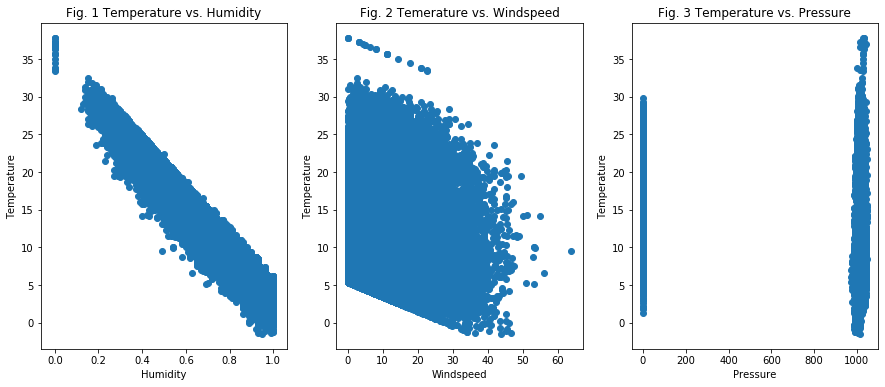

In [26]:
# Take a look at the predictions of the linear regression model
predictions = lrm.predict(weather_raw[["humidity","windspeed","pressure"]])
errors = Y - predictions

print(f"Mean of the errors in the temperature model is: {np.mean(errors)}")

# Plot the estimated Y & X for each feature
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.scatter(weather_raw["humidity"],predictions)
plt.xlabel("Humidity")
plt.ylabel("Temperature")
plt.title("Fig. 1 Temperature vs. Humidity")

plt.subplot(1,3,2)
plt.scatter(weather_raw["windspeed"],predictions)
plt.xlabel("Windspeed")
plt.ylabel("Temperature")
plt.title("Fig. 2 Temerature vs. Windspeed")

plt.subplot(1,3,3)
plt.scatter(weather_raw["pressure"],predictions)
plt.xlabel("Pressure")
plt.ylabel("Temperature")
plt.title("Fig. 3 Temperature vs. Pressure")

plt.show()

As demonstrated in $ Figs. 1,  2,  \&  3 $ the relationship between the relationship between the explanatory variables and the target variable is a linear one.

## Assumption Two: The Error Term Should be Zero on Average

The expected value (EV) of the error should be zero ( $ \mathbb{E} (\epsilon) = 0 $ ), for this model the EV of the error is: $ \mathbb{E} (\epsilon) = -1.03575 $ which means that the model systematically overpredicts the target variable and is therefore biased.

## Assumption Three: Homoscedasticity

Bartlett test statistic value is 2595.34 and p-value is   0
Levene test statistic value is 2435.450490232578 and p-value is 0.0


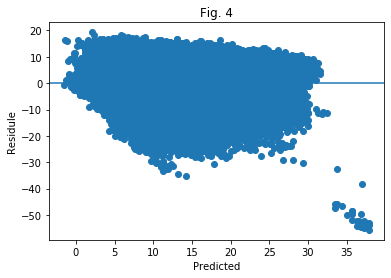

In [27]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p-value is {bart_stats[1]:3g}")
print(f"Levene test statistic value is {lev_stats[0]} and p-value is {lev_stats[1]}")

plt.scatter(predictions, errors)
plt.xlabel("Predicted")
plt.ylabel("Residule")
plt.title("Fig. 4")
plt.axhline(y=0)
plt.show();

The p-values for both tests are < 0.5.  The test results reject the null hypothesis meaning that the errors are heterscedastic.  

## Assumption Four: Low Multicollinearity

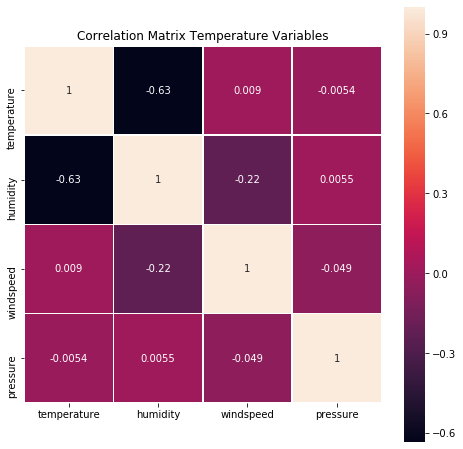

In [48]:
# Visual variable independence 
def corr_plot(corr_mat,figsize,title):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(title)

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();
    
corr_plot(
    corr_mat=weather_raw[["temperature","humidity","windspeed","pressure"]].corr(),
    figsize=(8,8),
    title=f"Correlation Matrix Temperature Variables")

For the variables in the temperature model, the variables are exibit lot multicollinearity.

## Assumption Five: Error Terms Should be Uncorrelated with One Another

[1.         0.97168085 0.957      0.94304862 0.92808089 0.91455123
 0.90197857 0.88966167 0.87861462 0.86810788 0.8576974  0.84834971
 0.83972385 0.83076863 0.82281469 0.81530643 0.80773029 0.80085958
 0.79471758 0.78809938 0.78247281 0.77730013 0.77150459 0.76543853
 0.75846511 0.75360623 0.74748183 0.74166312 0.73540575 0.72992798
 0.72504135 0.71915913 0.714498   0.70996711 0.70542253 0.70144888
 0.69765142 0.69361303 0.69059655 0.68777856 0.68440942]


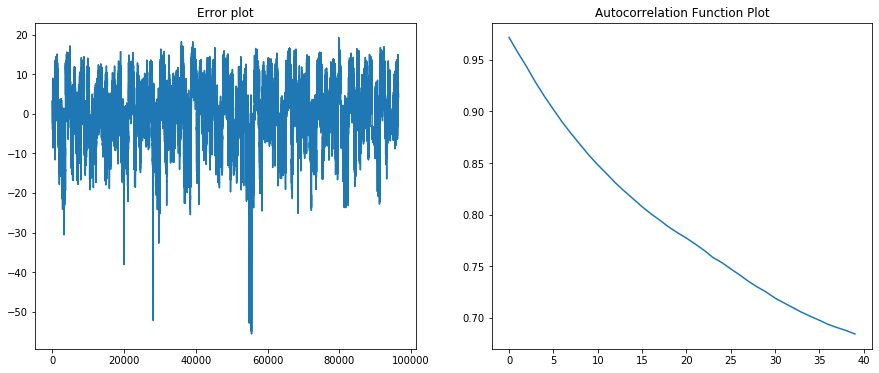

In [29]:
acf_data = acf(errors)
print(acf_data)

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(errors)
plt.title("Error plot")

plt.subplot(1,2,2)
plt.plot(acf_data[1:])
plt.title("Autocorrelation Function Plot")

plt.show();

The error terms of the temperature model are correlated with one another.  The autocorrelation between the errors = 1 

## Assumption Six: Features Shouldn't be Correlated with the Errors

Variable:  humidity --- correlation: 0.0000, p-value: 1.0000
Variable:  windspeed --- correlation: -0.0000, p-value: 1.0000
Variable:  pressure --- correlation: -0.0000, p-value: 1.0000


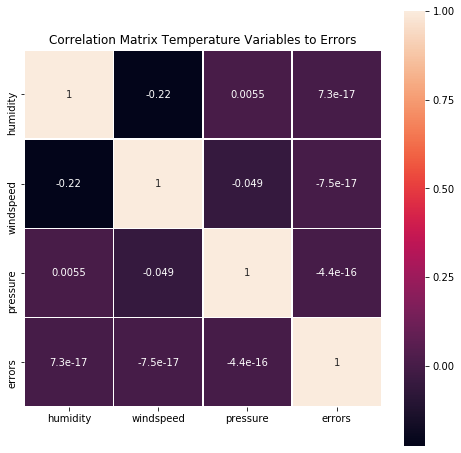

In [44]:
X_with_errors = X.copy()

X_with_errors["errors"] = Y - predictions

for col in X_with_errors[["humidity","windspeed","pressure"]].columns:
    corr_test = pearsonr(X_with_errors[col], X_with_errors["errors"])
    
    print(f"Variable:  {col} --- correlation: {corr_test[0]:.4f}, " 
          f"p-value: {corr_test[1]:.4f}")

corr_plot(
    corr_mat=X_with_errors.corr(),
    figsize=(8,8),
    title=f"Correlation Matrix Temperature Variables to Errors")

## Normality of the Errors

Jarque-Bera test statistic is: 3852.043000938128 and p-value is: 0.0
Normal Test statistic is: 3420.5077830836435 and p-value is: 0.0


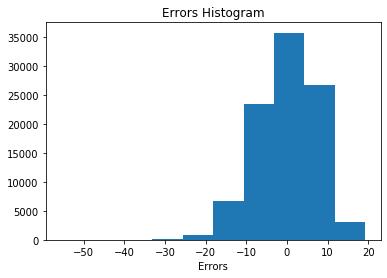

In [47]:
# Check to see if the distribution of errors is normal
jb_stats = jarque_bera(errors)
normal_test = normaltest(errors)

print(f"Jarque-Bera test statistic is: {jb_stats[0]} and p-value is: {jb_stats[1]}")
print(f"Normal Test statistic is: {normal_test[0]} and p-value is: {normal_test[1]}")

plt.hist(errors)
plt.xlabel("Errors")
plt.title("Errors Histogram")

plt.show();

The p-values for both Jarque-Bera and Normal Test are both zero, indicating that the errors are not normally distributed.